# 직접 만들어 보는 OCR

## 들어가며
이번 시간에는 OCR을 직접 만들어보는 시간을 갖도록 하겠습니다. OCR을 처음부터 끝까지 만들기에는 시간이 많이 소요되므로 Detection은 keras-ocr을 활용하고 Recognition을 직접 만들고 학습해보도록 하겠습니다.

## 실습목표
- Text Recognition 모델을 직접 구현해 봅니다.
- Text Recognition 모델 학습을 진행해 봅니다.
- Text Detection 모델과 연결하여 전체 OCR 시스템을 구현합니다.

## 목차
- Overall sturcture of OCR
- SynthText
- Recognition model
- End-to-End OCR


# 평가 루브릭

- 아래의 기준을 바탕으로 프로젝트를 평가합니다.

- 평가문항	상세기준
    1. [데이터셋관련] 학습 데이터셋을 효과적으로 전처리했는가? : OCR Dataset을 데이터를 정확히 로드했는가? Label Encoder를 정확하게 만들었는가? 이미지 처리 방법을 이해 했는가?
    2. [트레이닝 기법 관련] 학습을 위한 파라미터는 적절했는가? : GPU 메모리를 고려한 배치사이즈 설정, 배치사이즈에 따른 step크기 설정, 적절한 epoch 설정
    3. [정량적 수행결과 관련] 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가? : Recognition model의 inference가 성공적으로 동작하는가? Detection 모델의 inference결과를 눈으로 확인하였는가? Recognition 모델의 inference결과를 눈으로 확인하였는가?

# Dataset for OCR 준비하기

In [18]:
import warnings
warnings.filterwarnings("ignore")
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr_recognition_model')
os.chdir(path)

# Recognition model (1)
- 영문 대문자와 숫자를 인식하기 위해서는 몇가지의 Class가 필요할까요?

    - 총 36가지가 필요합니다. 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개가 됩니다.

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


- lmdb 설치하기
    - LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자
    - 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있음

- \$ pip install lmdb
- 필요한 라이브러리들을 import하고, 다운로드한 MJ 데이터셋의 위치 옮기기

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr_recognition_model'

TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

In [4]:
TRAIN_DATA_PATH

'/home/aiffel0042/aiffel/ocr_recognition_model/MJ/MJ_train'

In [5]:
VALID_DATA_PATH

'/home/aiffel0042/aiffel/ocr_recognition_model/MJ/MJ_valid'

In [6]:
TEST_DATA_PATH

'/home/aiffel0042/aiffel/ocr_recognition_model/MJ/MJ_test'

# Recognition model (2) Input Image
- 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해 본다.
    - lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인해 본다.



original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


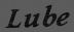

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


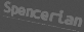

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


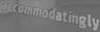

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


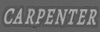

In [7]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- 대부분의 이미지의 height는 31, 최대 32까지로 되어 있고, width는 문자열 길이에 따라 다양하다.

- lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현한다. 
- label_converter는 문자를 미리정의된 index로 변환해주는 converter로 직접 구현한다.
- batch_size와 입력이미지 크기, 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있다.

In [8]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        # Return image array and label in string
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

- 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영됨
- model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label() 를 통해 가져온 데이터셋을 리턴하게 됨
- _get_img_label() 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있다.

# Recognition model (3) Encode
- LabelConverter 클래스를 작성해봅시다.
    - Label은 우리가 읽을 수 있는 평문 Text로 이루어져 있는데, 이는 모델을 학습하기 위해서 적절한 형태가 아니므로, 
    - 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해준다.

- __init__() 에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장한다. 
    - 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어진다. 

- decode는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어준다.

- encode를 모델이 학습할 수 있는 label로 만들어 준다.

In [9]:
class LabelConverter(object):
    """ Convert between text-label and text-index """
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

- 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해본다.

In [10]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


# Recognition model (4) Build CRNN model
- 입력과 출력을 준비했으니 모델을 만들어볼 차례이다.
- Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func을 만들어준다. 

In [11]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

- 여기서 잠시 Keras의 K.ctc\_batch\_cost() 함수에 대해 짚고 넘어갑시다. 비록 우리가 이 함수 내부를 직접 구현하진 않겠지만 CTC Loss 함수를 구현하기 위해 우리가 이 함수에 인자로 어떤 값을 넘겨야 하는지는 명확하게 파악해야 합니다.

![title](ctc.png)

- 우리는 CTC Loss를 활용해야 하는 모델이 위 그림과 같은 상황을 다루기 위한 것임을 알고 있습니다. 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 그래서 라벨은 APPLE이지만 모델이 출력한 결과는 AAAPPPPLLLLEE 처럼 나올 수 있습니다. 이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용됩니다.

- 위 텐서플로우 튜토리얼에 따르면, K.ctc_batch_cost(y_true, y_pred, input_length, label_length)에는 4가지 인자가 존재합니다. 각각의 인자의 의미는 다음과 같습니다.

    - y_true: tensor (samples, max_string_length) containing the truth labels.
    - y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
    - input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
    - label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.
    - (여기서 samples는 배치사이즈를 의미합니다.)

![title](GC-6-P-example.png)

- 위 그림은 이전 스텝에서 살펴본 실제 데이터셋 예시입니다. 이 케이스를 예로 들었을 때 위 인자들은 다음과 같이 될 것입니다.

    - y_true: 실제 라벨 LUBE. 그러나 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
    - y_pred: 우리가 만들 RCNN 모델의 출력 결과. 그러나 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
    - input_length tensor: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
    - label_length tensor: 라벨의 실제 정답 길이 U로서, 이 경우에는 4

- 이제, K.ctc_batch_cost()를 활용하여, image_input을 입력으로 그리고 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 봅시다.


In [12]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

# Recognition model (5) Train & Inference
- 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜본다.

In [13]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=300,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/300
63/63 [==============================] - ETA: 0s - loss: 29.1821
Epoch 00001: val_loss improved from inf to 27.09659, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 9s 135ms/step - loss: 29.1821 - val_loss: 27.0966
Epoch 2/300
63/63 [==============================] - ETA: 0s - loss: 26.4384
Epoch 00002: val_loss improved from 27.09659 to 26.72703, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 8s 125ms/step - loss: 26.4384 - val_loss: 26.7270
Epoch 3/300
63/63 [==============================] - ETA: 0s - loss: 26.0434
Epoch 00003: val_loss improved from 26.72703 to 26.26892, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 8s 120ms/step - loss: 26.0434 - val_loss: 26.2689
Epoch 4/300
63/63 [==============================] - ETA: 0s - loss: 25.775

Epoch 30/300
63/63 [==============================] - ETA: 0s - loss: 5.8349
Epoch 00030: val_loss improved from 6.85434 to 6.20166, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 8s 121ms/step - loss: 5.8349 - val_loss: 6.2017
Epoch 31/300
63/63 [==============================] - ETA: 0s - loss: 6.1468
Epoch 00031: val_loss did not improve from 6.20166
63/63 [==============================] - 7s 119ms/step - loss: 6.1468 - val_loss: 6.4163
Epoch 32/300
63/63 [==============================] - ETA: 0s - loss: 5.5350
Epoch 00032: val_loss improved from 6.20166 to 6.11765, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 8s 121ms/step - loss: 5.5350 - val_loss: 6.1177
Epoch 33/300
63/63 [==============================] - ETA: 0s - loss: 5.7963
Epoch 00033: val_loss improved from 6.11765 to 5.94530, saving model to /home/aiffel0042/aiffe

Epoch 59/300
63/63 [==============================] - ETA: 0s - loss: 3.5878
Epoch 00059: val_loss did not improve from 3.92368
63/63 [==============================] - 7s 116ms/step - loss: 3.5878 - val_loss: 4.1550
Epoch 60/300
63/63 [==============================] - ETA: 0s - loss: 3.7877
Epoch 00060: val_loss did not improve from 3.92368
63/63 [==============================] - 7s 116ms/step - loss: 3.7877 - val_loss: 4.1747
Epoch 61/300
63/63 [==============================] - ETA: 0s - loss: 3.7976
Epoch 00061: val_loss did not improve from 3.92368
63/63 [==============================] - 7s 116ms/step - loss: 3.7976 - val_loss: 4.0815
Epoch 62/300
63/63 [==============================] - ETA: 0s - loss: 3.7817
Epoch 00062: val_loss improved from 3.92368 to 3.84750, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 8s 120ms/step - loss: 3.7817 - val_loss: 3.8475
Epoch 63/300
63/63 [=======================

63/63 [==============================] - ETA: 0s - loss: 2.9711
Epoch 00091: val_loss improved from 3.11142 to 3.03102, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 8s 119ms/step - loss: 2.9711 - val_loss: 3.0310
Epoch 92/300
63/63 [==============================] - ETA: 0s - loss: 2.9330
Epoch 00092: val_loss did not improve from 3.03102
63/63 [==============================] - 7s 117ms/step - loss: 2.9330 - val_loss: 3.1215
Epoch 93/300
63/63 [==============================] - ETA: 0s - loss: 2.9168
Epoch 00093: val_loss did not improve from 3.03102
63/63 [==============================] - 7s 115ms/step - loss: 2.9168 - val_loss: 3.0365
Epoch 94/300
63/63 [==============================] - ETA: 0s - loss: 2.9551
Epoch 00094: val_loss did not improve from 3.03102
63/63 [==============================] - 7s 116ms/step - loss: 2.9551 - val_loss: 3.1271
Epoch 95/300
63/63 [==============================] - ET

Epoch 125/300
63/63 [==============================] - ETA: 0s - loss: 2.6559
Epoch 00125: val_loss improved from 2.61418 to 2.57672, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 7s 118ms/step - loss: 2.6559 - val_loss: 2.5767
Epoch 126/300
63/63 [==============================] - ETA: 0s - loss: 2.6124
Epoch 00126: val_loss did not improve from 2.57672
63/63 [==============================] - 7s 116ms/step - loss: 2.6124 - val_loss: 2.5809
Epoch 127/300
63/63 [==============================] - ETA: 0s - loss: 2.5542
Epoch 00127: val_loss did not improve from 2.57672
63/63 [==============================] - 7s 116ms/step - loss: 2.5542 - val_loss: 2.6132
Epoch 128/300
63/63 [==============================] - ETA: 0s - loss: 2.5619
Epoch 00128: val_loss improved from 2.57672 to 2.54338, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] 

63/63 [==============================] - ETA: 0s - loss: 2.3708
Epoch 00157: val_loss did not improve from 2.34755
63/63 [==============================] - 7s 116ms/step - loss: 2.3708 - val_loss: 2.3600
Epoch 158/300
63/63 [==============================] - ETA: 0s - loss: 2.3639
Epoch 00158: val_loss did not improve from 2.34755
63/63 [==============================] - 7s 116ms/step - loss: 2.3639 - val_loss: 2.3946
Epoch 159/300
63/63 [==============================] - ETA: 0s - loss: 2.2874
Epoch 00159: val_loss improved from 2.34755 to 2.32363, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 7s 118ms/step - loss: 2.2874 - val_loss: 2.3236
Epoch 160/300
63/63 [==============================] - ETA: 0s - loss: 2.1022
Epoch 00160: val_loss improved from 2.32363 to 2.28681, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 8s 119ms/ste

Epoch 191/300
63/63 [==============================] - ETA: 0s - loss: 2.1203
Epoch 00191: val_loss did not improve from 2.14530
63/63 [==============================] - 7s 116ms/step - loss: 2.1203 - val_loss: 2.1589
Epoch 192/300
63/63 [==============================] - ETA: 0s - loss: 2.0120
Epoch 00192: val_loss did not improve from 2.14530
63/63 [==============================] - 7s 116ms/step - loss: 2.0120 - val_loss: 2.1651
Epoch 193/300
63/63 [==============================] - ETA: 0s - loss: 2.0932
Epoch 00193: val_loss improved from 2.14530 to 2.09370, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 7s 118ms/step - loss: 2.0932 - val_loss: 2.0937
Epoch 194/300
63/63 [==============================] - ETA: 0s - loss: 2.1094
Epoch 00194: val_loss did not improve from 2.09370
63/63 [==============================] - 7s 117ms/step - loss: 2.1094 - val_loss: 2.1448
Epoch 195/300
63/63 [==================

Epoch 226/300
63/63 [==============================] - ETA: 0s - loss: 2.0216
Epoch 00226: val_loss did not improve from 1.96730
63/63 [==============================] - 7s 116ms/step - loss: 2.0216 - val_loss: 2.0238
Epoch 227/300
63/63 [==============================] - ETA: 0s - loss: 2.0074
Epoch 00227: val_loss did not improve from 1.96730
63/63 [==============================] - 7s 116ms/step - loss: 2.0074 - val_loss: 1.9991
Epoch 228/300
63/63 [==============================] - ETA: 0s - loss: 1.9591
Epoch 00228: val_loss improved from 1.96730 to 1.95255, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 7s 118ms/step - loss: 1.9591 - val_loss: 1.9526
Epoch 229/300
63/63 [==============================] - ETA: 0s - loss: 1.8391
Epoch 00229: val_loss did not improve from 1.95255
63/63 [==============================] - 7s 117ms/step - loss: 1.8391 - val_loss: 1.9848
Epoch 230/300
63/63 [==================

63/63 [==============================] - ETA: 0s - loss: 1.8236
Epoch 00260: val_loss did not improve from 1.86541
63/63 [==============================] - 7s 117ms/step - loss: 1.8236 - val_loss: 1.9247
Epoch 261/300
63/63 [==============================] - ETA: 0s - loss: 1.8297
Epoch 00261: val_loss did not improve from 1.86541
63/63 [==============================] - 7s 116ms/step - loss: 1.8297 - val_loss: 1.8704
Epoch 262/300
63/63 [==============================] - ETA: 0s - loss: 1.6969
Epoch 00262: val_loss did not improve from 1.86541
63/63 [==============================] - 7s 116ms/step - loss: 1.6969 - val_loss: 1.9086
Epoch 263/300
63/63 [==============================] - ETA: 0s - loss: 1.7606
Epoch 00263: val_loss did not improve from 1.86541
63/63 [==============================] - 7s 116ms/step - loss: 1.7606 - val_loss: 1.8775
Epoch 264/300
63/63 [==============================] - ETA: 0s - loss: 1.8668
Epoch 00264: val_loss improved from 1.86541 to 1.83524, saving m

Epoch 296/300
63/63 [==============================] - ETA: 0s - loss: 1.7137
Epoch 00296: val_loss improved from 1.77634 to 1.74649, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/model_checkpoint.hdf5
63/63 [==============================] - 7s 118ms/step - loss: 1.7137 - val_loss: 1.7465
Epoch 297/300
63/63 [==============================] - ETA: 0s - loss: 1.6942
Epoch 00297: val_loss did not improve from 1.74649
63/63 [==============================] - 7s 117ms/step - loss: 1.6942 - val_loss: 1.7530
Epoch 298/300
63/63 [==============================] - ETA: 0s - loss: 1.6721
Epoch 00298: val_loss did not improve from 1.74649
63/63 [==============================] - 7s 116ms/step - loss: 1.6721 - val_loss: 1.7840
Epoch 299/300
63/63 [==============================] - ETA: 0s - loss: 1.7093
Epoch 00299: val_loss did not improve from 1.74649
63/63 [==============================] - 7s 116ms/step - loss: 1.7093 - val_loss: 1.8290
Epoch 300/300
63/63 [==================

- 학습한 모델을 테스트셋에서 inference해보고 이를 눈으로 직접 확인해본다.

Result: 	 SLINKING9999999999999999


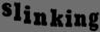

Result: 	 ALEPPO99999999999999999


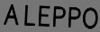

Result: 	 RWANDA999999999999999999


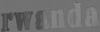

Result: 	 NATHANS99999999999999999


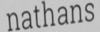

Result: 	 HALLO999999999999999999


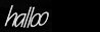

Result: 	 HURLS9999999999999999999


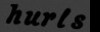

Result: 	 DOWNSIZE9999999999999999


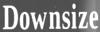

Result: 	 ROBOTIC99999999999999999


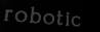

Result: 	 SLOPPY99999999999999999


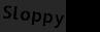

Result: 	 HERMITE99999999999999999


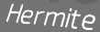

In [19]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

# 프로젝트: End-to-End OCR

- keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다. 이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요. 위의 사진 sample.jpg도 ocr폴더에 다운받으셔야합니다.



In [192]:
from keras_ocr.detection import Detector
from PIL import ImageDraw, Image
SAMPLE_IMG_PATH = 'sample.jpg'
detector = Detector()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


- 이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 그리고 단어의 영역을 잘라오도록 해주세요.

In [198]:
# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]

In [201]:
def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다. 
    detect_result = detector.detect(img.numpy())

    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = detect_result[0]

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw = ImageDraw.Draw(img_pil)
    result_img = img_pil
        
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return result_img, cropped_imgs

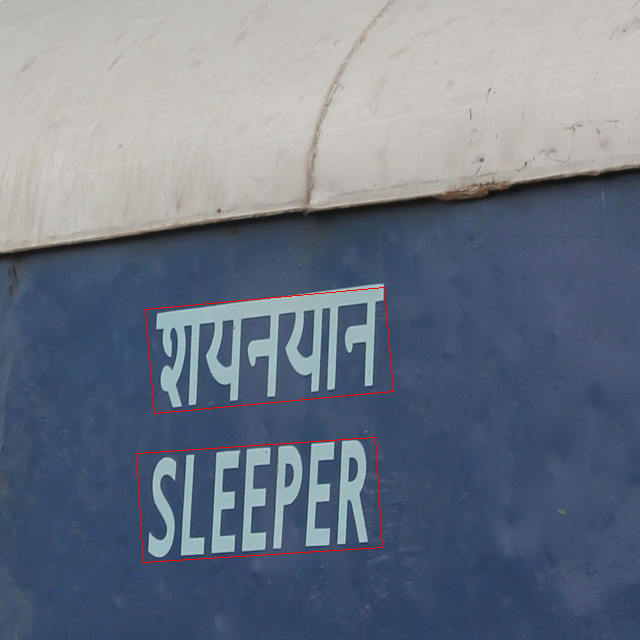

In [202]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

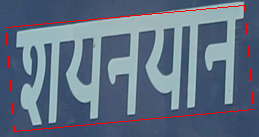

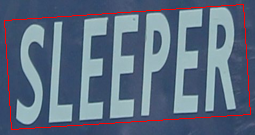

In [203]:
for sub_img in cropped_img:
    display(sub_img)

- 이제 위에서 이미지 내의 단어 이미지를 얻었습니다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!

In [204]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 QRUEN9999999999999999999


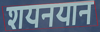

Result: 	 SLEEPERS999999999999999


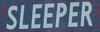

In [205]:
for _img in cropped_img:
    recognize_img(_img)

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


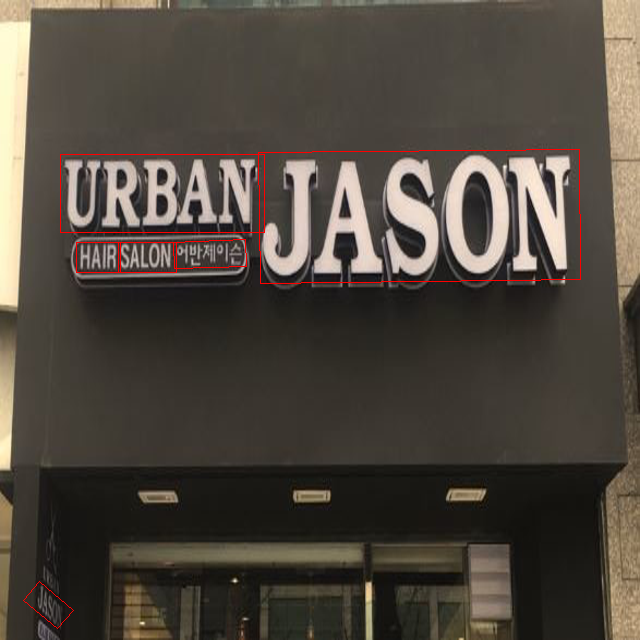

In [224]:
SAMPLE_IMG_PATH = 'sample1.jpg'
detector = Detector()

# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]
detect_result = detector.detect(img.numpy())

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

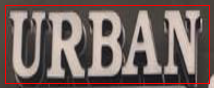

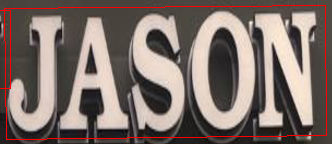

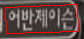

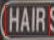

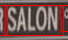

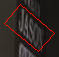

In [225]:
for sub_img in cropped_img:
    display(sub_img)

Result: 	 URBAN9999999999999999999


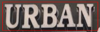

Result: 	 JASON9999999999999999999


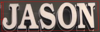

Result: 	 CIRCE9999999999999999999


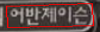

Result: 	 GHARS9999999999999999999


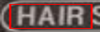

Result: 	 SALONE999999999999999999


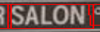

Result: 	 E99999999999999999999999


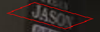

In [226]:
for _img in cropped_img:
    recognize_img(_img)

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


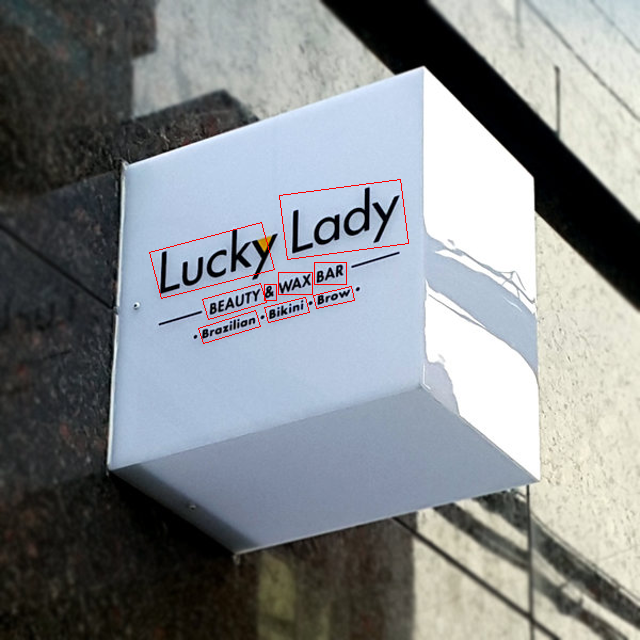

In [215]:
SAMPLE_IMG_PATH = 'sample3.jpeg'
detector = Detector()

# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]
detect_result = detector.detect(img.numpy())

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

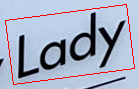

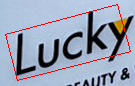

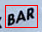

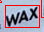

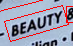

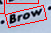

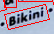

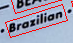

In [218]:
for sub_img in cropped_img:
    display(sub_img)

Result: 	 LADYS9999999999999999999


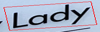

Result: 	 LUCKY9999999999999999999


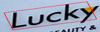

Result: 	 NEAN99999999999999999999


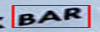

Result: 	 LAE999999999999999999999


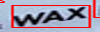

Result: 	 OS9999999999999999999999


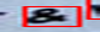

Result: 	 REAUIG999999999999999999


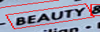

Result: 	 RELOS9999999999999999999


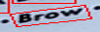

Result: 	 REKILY999999999999999999


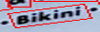

Result: 	 REREMILENT99999999999999


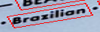

In [219]:
for _img in cropped_img:
    recognize_img(_img)

# 결론
- 300 epochs으로 학습 시켜서 validation loss를 1.74649까지 줄였다. (100 epochs = 2.92478, 200 epochs = 2.06616)
- 영어에 대한 인식율은 높지만, 한국어나 아랍어 등 다른 나라의 언어에 대한 인식율을 낮았다. 
- 프로젝트에서 주어진 Sample 이미지 외에 추가적으로 2개를 더 돌려서 결과를 비교 분석해 보았다. 

## 첫번째 샘플 이미지

![title](sample_result1.png)
![title](sample_result2.png)

- 단어간의 간격이 충분이 멀기 때문에, 각 단어의 위치를 잘 찾아내었다.
- 아랍어는 인식하지 못했으나, 영어는 잘 인식하였다. 

## 두번째 샘플 이미지

![title](sample2_result.png)
![title](sample2_result1.png)

- 다양하게 존재하는 작고 큰 단어 영역을 잘 잡아내었다. 아래 왼쪽 벽에 위치하는 작은 단어도 찾아내었다.
- HAIR 같은 경우에는 주변에 있는 둥그런 테두리 부분과 구분하지 못해서 GHAIR로 잘못인식 하였다.
- 왼쪽 아래 벽면에 아주 작게 보이는 JASON이라는 단어를 찾아내긴 했지만, 글자 인식을 잘 하지 못했다. 

## 세번째 샘플 이미지

![title](sample3_result.png)
![title](sample3_result1.png)

- 오밀 조밀하게 붙어있는 다양한 단어들을 잘 구분해서 찾아내었다. 
- 하지만 단어들이 많이 기울어져있고, 작아서 그런지 인식율이 매우 낮았다. 